In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torchvision as tv
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Загружаем данные

In [2]:
batch_size = 8
TRAIN_PATH = './hymenoptera_data/train/'
TEST_PATH = './hymenoptera_data/val/'
transform_img = tv.transforms.Compose([
    tv.transforms.Resize((256, 256)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)) 
])

train_data = tv.datasets.ImageFolder(root=TRAIN_PATH, transform=transform_img)
test_data = tv.datasets.ImageFolder(root=TEST_PATH, transform=transform_img)

In [3]:
train_iter = DataLoader(dataset=train_data, batch_size=batch_size,shuffle=True) 
test_iter = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [4]:
len(train_data)

244

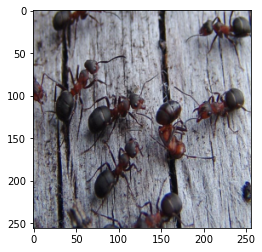

In [5]:
def imshow(img):
    img = img * 0.5 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show();
imshow(train_data[17][0])

### для тренировки и оценки

In [14]:
def evaluate(model, test_iter, dev):    
    model.eval()
    with torch.no_grad():
        acc_sum = 0
        count = 0
        for X, y in test_iter:
            X, y = X.to(dev), y.to(dev)
            acc_sum += (model(X).argmax(axis=1) == y).sum().item()
            count += y.shape[0]       
        return acc_sum / count
    
def train_net(train_iter, test_iter, model, epochs, trainer):
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(dev)
    
    loss = nn.CrossEntropyLoss(reduction='sum')
    
    for epoch in range(1, epochs + 1):
        train_loss_sum, train_acc_sum, count, start = 0.0, 0.0, 0, time.time()
        
        model.train()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            predict = model(X)
            l = loss(predict, y)
            l.backward()
            trainer.step()
            train_loss_sum += l.item()
            train_acc_sum += (predict.argmax(axis=1) == y).sum().item()
            count += y.shape[0]
                        
        train_acc = train_acc_sum / count
        train_loss  = train_loss_sum / count
        test_acc = evaluate(model, test_iter, dev)
        run = time.time() - start
        
        print(f"epoch = {epoch}, train_acc = {train_acc:.7f}, train_loss = {train_loss:.7f}, test_acc = {test_acc:.7f}, time = {run:.7f}")

# ResNet 18 "с нуля"

In [7]:
resnet18 = tv.models.resnet18(pretrained=False)

In [8]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
resnet18.fc = nn.Linear(in_features=512, out_features=2)

In [10]:
lr, epochs = 0.001, 10
trainer = torch.optim.AdamW(resnet18.parameters(), lr=lr)
train_net(train_iter, test_iter, resnet18, epochs, trainer)

epoch = 1, train_acc = 0.5327869, train_loss = 0.8806498, test_acc = 0.4836601, time = 4.7177417
epoch = 2, train_acc = 0.6311475, train_loss = 0.6615048, test_acc = 0.6405229, time = 3.6457860
epoch = 3, train_acc = 0.6680328, train_loss = 0.5990951, test_acc = 0.6078431, time = 3.5543673
epoch = 4, train_acc = 0.6844262, train_loss = 0.6400424, test_acc = 0.6339869, time = 3.6028423
epoch = 5, train_acc = 0.6639344, train_loss = 0.6226162, test_acc = 0.6535948, time = 3.8576043
epoch = 6, train_acc = 0.6311475, train_loss = 0.6869754, test_acc = 0.5098039, time = 3.5433292
epoch = 7, train_acc = 0.6188525, train_loss = 0.6940485, test_acc = 0.6405229, time = 3.5421684
epoch = 8, train_acc = 0.6065574, train_loss = 0.6893908, test_acc = 0.6862745, time = 3.6329837
epoch = 9, train_acc = 0.6557377, train_loss = 0.6322425, test_acc = 0.6928105, time = 3.5394540
epoch = 10, train_acc = 0.6434426, train_loss = 0.6494824, test_acc = 0.7124183, time = 3.4289587


# Предобученная сеть ResNet 18

In [11]:
resnet = tv.models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(in_features=512, out_features=2)   

In [12]:
lr, epochs = 0.001, 10
trainer = torch.optim.AdamW(resnet.parameters(), lr=lr)
train_net(train_iter, test_iter, resnet, epochs, trainer)

epoch = 1, train_acc = 0.6557377, train_loss = 0.6383930, test_acc = 0.8562092, time = 2.9054124
epoch = 2, train_acc = 0.8032787, train_loss = 0.4378769, test_acc = 0.8954248, time = 2.9534791
epoch = 3, train_acc = 0.8688525, train_loss = 0.3499611, test_acc = 0.9019608, time = 2.9972792
epoch = 4, train_acc = 0.8688525, train_loss = 0.3232804, test_acc = 0.9215686, time = 3.2001116
epoch = 5, train_acc = 0.8647541, train_loss = 0.3088010, test_acc = 0.9281046, time = 3.1669087
epoch = 6, train_acc = 0.8975410, train_loss = 0.2454045, test_acc = 0.9215686, time = 3.1973031
epoch = 7, train_acc = 0.9016393, train_loss = 0.2406160, test_acc = 0.9281046, time = 3.1441853
epoch = 8, train_acc = 0.9221311, train_loss = 0.2216129, test_acc = 0.8954248, time = 3.1127231
epoch = 9, train_acc = 0.9262295, train_loss = 0.2028734, test_acc = 0.9084967, time = 3.0130727
epoch = 10, train_acc = 0.9385246, train_loss = 0.1951936, test_acc = 0.9150327, time = 3.0282707


# VGG 16 "с нуля"

In [13]:
vgg16 = tv.models.vgg16(pretrained=False)

In [14]:
vgg16.fc = nn.Linear(in_features=1000, out_features=2)
# надо ли переписывать vgg16.classifier или можно добавить vgg16.fc? 
# (на предаобученной модели добавление vgg16.fc не работает, т.к. .fc в vgg16 не определен, об этом есть ответ на вопрос в документации
# но если добавлять в vgg16 с нуля - работает)

In [15]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
lr, epochs = 0.001, 10
trainer = torch.optim.AdamW(vgg16.parameters(), lr=lr)
train_net(train_iter, test_iter, vgg16, epochs, trainer)

epoch = 1, train_acc = 0.4836066, train_loss = 11.8265613, test_acc = 0.5424837, time = 10.1263456
epoch = 2, train_acc = 0.5163934, train_loss = 0.7090346, test_acc = 0.5424837, time = 10.0621994
epoch = 3, train_acc = 0.5081967, train_loss = 0.7207169, test_acc = 0.5424837, time = 10.1401381
epoch = 4, train_acc = 0.5204918, train_loss = 0.7464804, test_acc = 0.4575163, time = 10.1567299
epoch = 5, train_acc = 0.4836066, train_loss = 0.7272418, test_acc = 0.4575163, time = 10.1848969
epoch = 6, train_acc = 0.5286885, train_loss = 0.6985691, test_acc = 0.4575163, time = 10.1745474
epoch = 7, train_acc = 0.4631148, train_loss = 0.7311358, test_acc = 0.5424837, time = 10.1028440
epoch = 8, train_acc = 0.5532787, train_loss = 0.7101320, test_acc = 0.5424837, time = 9.9762614
epoch = 9, train_acc = 0.5245902, train_loss = 0.7412959, test_acc = 0.5424837, time = 9.9832423
epoch = 10, train_acc = 0.5081967, train_loss = 0.7183449, test_acc = 0.5424837, time = 10.0989554


# Предобученная сеть VGG 16

In [17]:
vgg16 = tv.models.vgg16(pretrained=True)

for param in vgg16.parameters():
    if param.requires_grad:
        param.requires_grad = False  

In [18]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [19]:
vgg16.classifier.add_module( '7', nn.ReLU())
vgg16.classifier.add_module( '8', nn.Linear(1000, 2))

In [20]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
lr, epochs = 0.001, 10
trainer = torch.optim.AdamW(vgg16.parameters(), lr=lr)
train_net(train_iter, test_iter, vgg16, epochs, trainer)

epoch = 1, train_acc = 0.7950820, train_loss = 0.4130117, test_acc = 0.8692810, time = 5.3935678
epoch = 2, train_acc = 0.9303279, train_loss = 0.1874136, test_acc = 0.9477124, time = 5.4839346
epoch = 3, train_acc = 0.9467213, train_loss = 0.1289819, test_acc = 0.9281046, time = 5.2394996
epoch = 4, train_acc = 0.9549180, train_loss = 0.1367842, test_acc = 0.9281046, time = 5.4595728
epoch = 5, train_acc = 0.9590164, train_loss = 0.0945154, test_acc = 0.9411765, time = 5.4540441
epoch = 6, train_acc = 0.9795082, train_loss = 0.0792055, test_acc = 0.9477124, time = 5.6579285
epoch = 7, train_acc = 0.9549180, train_loss = 0.0875702, test_acc = 0.9477124, time = 5.5889306
epoch = 8, train_acc = 0.9631148, train_loss = 0.0821709, test_acc = 0.9346405, time = 5.3424041
epoch = 9, train_acc = 0.9836066, train_loss = 0.0541433, test_acc = 0.9346405, time = 5.3062513
epoch = 10, train_acc = 0.9631148, train_loss = 0.0781715, test_acc = 0.9281046, time = 5.3509934


# Add augmentation

In [22]:
batch_size = 8
TRAIN_PATH = './hymenoptera_data/train/'
TEST_PATH = './hymenoptera_data/val/'
transform_img = tv.transforms.Compose([
    tv.transforms.Resize((256, 256)),
    tv.transforms.RandomGrayscale(0.1),
    tv.transforms.RandomHorizontalFlip(p=0.3),
    tv.transforms.RandomVerticalFlip(p=0.2),
    tv.transforms.RandomCrop(size=(200, 200)),
#     tv.transforms.RandomRotation(degrees=(0, 180)),    
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)), 

])

train_data_aug = tv.datasets.ImageFolder(root=TRAIN_PATH, transform=transform_img)
test_data_aug = tv.datasets.ImageFolder(root=TEST_PATH, transform=transform_img)
train_iter_aug = DataLoader(dataset=train_data_aug, batch_size=batch_size,shuffle=True) 
test_iter_aug = DataLoader(dataset=test_data_aug, batch_size=batch_size, shuffle=False)

In [23]:
# при аугментации данные меняются на каждой эпохе случайным образом? размер датасета не меняется?

### resnet18

In [24]:
resnet = tv.models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(in_features=512, out_features=2)   

lr, epochs = 0.0001, 50
trainer = torch.optim.AdamW(resnet.parameters(), lr=lr)
train_net(train_iter_aug, test_iter_aug, resnet, epochs, trainer)

epoch = 1, train_acc = 0.5532787, train_loss = 0.6936522, test_acc = 0.6013072, time = 2.8744986
epoch = 2, train_acc = 0.5942623, train_loss = 0.6614578, test_acc = 0.5882353, time = 2.7934318
epoch = 3, train_acc = 0.6311475, train_loss = 0.6358978, test_acc = 0.7124183, time = 2.9420421
epoch = 4, train_acc = 0.6844262, train_loss = 0.6141612, test_acc = 0.7777778, time = 3.3312101
epoch = 5, train_acc = 0.7254098, train_loss = 0.5639749, test_acc = 0.7777778, time = 3.0268466
epoch = 6, train_acc = 0.7868852, train_loss = 0.5328586, test_acc = 0.8039216, time = 2.9221103
epoch = 7, train_acc = 0.8073770, train_loss = 0.5051600, test_acc = 0.8627451, time = 3.2670786
epoch = 8, train_acc = 0.8237705, train_loss = 0.4980409, test_acc = 0.8758170, time = 2.9566057
epoch = 9, train_acc = 0.8319672, train_loss = 0.4685538, test_acc = 0.8823529, time = 3.0011590
epoch = 10, train_acc = 0.8032787, train_loss = 0.4680951, test_acc = 0.8758170, time = 3.3396378
epoch = 11, train_acc = 0.856

### vgg16

In [25]:
vgg16 = tv.models.vgg16(pretrained=True)

for param in vgg16.parameters():
    if param.requires_grad:
        param.requires_grad = False  

In [26]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
vgg16.classifier.add_module('7', nn.ReLU())
vgg16.classifier.add_module('8', nn.Linear(1000, 2))
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1000, out_features=2, bias=True)
)


In [28]:
lr, epochs = 0.001, 10
trainer = torch.optim.AdamW(vgg16.parameters(), lr=lr)
train_net(train_iter_aug, test_iter_aug, vgg16, epochs, trainer)

epoch = 1, train_acc = 0.7827869, train_loss = 0.4305049, test_acc = 0.9281046, time = 4.3709626
epoch = 2, train_acc = 0.9180328, train_loss = 0.1889623, test_acc = 0.9150327, time = 4.3655517
epoch = 3, train_acc = 0.9057377, train_loss = 0.2096091, test_acc = 0.8954248, time = 4.3988695
epoch = 4, train_acc = 0.9303279, train_loss = 0.1571849, test_acc = 0.9542484, time = 4.4047089
epoch = 5, train_acc = 0.9549180, train_loss = 0.1219406, test_acc = 0.9215686, time = 4.4198332
epoch = 6, train_acc = 0.9221311, train_loss = 0.1496628, test_acc = 0.9346405, time = 4.4297731
epoch = 7, train_acc = 0.9344262, train_loss = 0.1536716, test_acc = 0.9346405, time = 4.5071805
epoch = 8, train_acc = 0.9344262, train_loss = 0.1592667, test_acc = 0.9215686, time = 4.3995891
epoch = 9, train_acc = 0.9672131, train_loss = 0.1079097, test_acc = 0.8888889, time = 4.3371899
epoch = 10, train_acc = 0.9590164, train_loss = 0.1358745, test_acc = 0.9084967, time = 4.3003070


# применение модели (отсебятина)

In [25]:
from PIL import Image

In [26]:
#  взято с https://www.machinelearningmastery.ru/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7/
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [27]:
#  взято с https://www.machinelearningmastery.ru/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7/
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 256 x 256
    left = (width - 256)/2
    top = (height - 256)/2
    right = (width + 256)/2
    bottom = (height + 256)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [28]:
# ! wget -O 'ant.jpg' 'https://lh3.googleusercontent.com/proxy/WTQCEnVIk1jz7_cQA88c74ujLgNwXW29OUbDh_7NwXHHjWOeKV2PVuSdQUn_FoVG6AoB9BKGtolwOJ4WxBAY8kPJbHPg'

In [29]:
# !wget -O 'bee.jpg' 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQQ_faP5bskzIhK0uUkV0vgmklCDW0O7pP4OQ&usqp=CAU'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


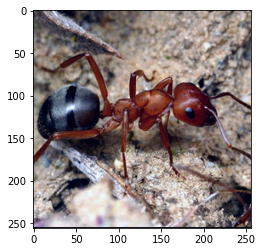

In [30]:
img = process_image('ant.jpg')
show_image(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


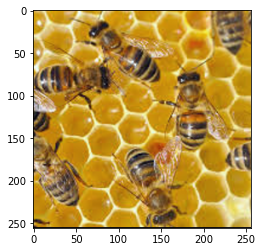

In [31]:
img_2 = process_image('bee.jpg')
show_image(img_2)

In [36]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [37]:
vgg16(img.to(dev)).argmax(axis=1).item()

0

In [38]:
vgg16(img_2.to(dev)).argmax(axis=1).item()

1

# FashionMnist

In [9]:
batch_size = 8
transform_img = tv.transforms.Compose([
    tv.transforms.Resize((128, 128)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.5], std=[0.5])
])

In [10]:
train_dataset_2 = tv.datasets.FashionMNIST('.', train=True, transform=transform_img, download=True)
test_dataset_2  = tv.datasets.FashionMNIST('.', train=False, transform=transform_img, download=True)
train_iter_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size=batch_size)
test_iter_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size=batch_size)

In [11]:
train_dataset_2.data.shape

torch.Size([60000, 28, 28])

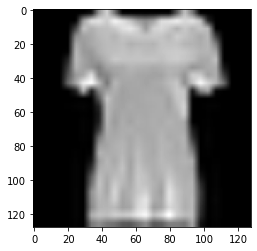

In [12]:
plt.imshow(train_dataset_2[10][0].numpy().reshape(128, 128), cmap='gray')

In [43]:
resnet = tv.models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(in_features=512, out_features=10)   



In [44]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [46]:
lr, epochs = 0.001, 10
trainer = torch.optim.AdamW(resnet.parameters(), lr=lr)
train_net(train_iter_2, test_iter_2, resnet, epochs, trainer)

epoch = 1, train_acc = 0.7649167, train_loss = 0.6741093, test_acc = 0.8170000, time = 104.0992160
epoch = 2, train_acc = 0.8026000, train_loss = 0.5639803, test_acc = 0.8223000, time = 105.3520286
epoch = 3, train_acc = 0.8114833, train_loss = 0.5388954, test_acc = 0.8304000, time = 105.6259162
epoch = 4, train_acc = 0.8158500, train_loss = 0.5245304, test_acc = 0.8291000, time = 106.5646381
epoch = 5, train_acc = 0.8197500, train_loss = 0.5158775, test_acc = 0.8284000, time = 105.7758486
epoch = 6, train_acc = 0.8216500, train_loss = 0.5094785, test_acc = 0.8380000, time = 106.9263480
epoch = 7, train_acc = 0.8239000, train_loss = 0.5034952, test_acc = 0.8345000, time = 105.5752506
epoch = 8, train_acc = 0.8251833, train_loss = 0.4997796, test_acc = 0.8297000, time = 105.5314317
epoch = 9, train_acc = 0.8272000, train_loss = 0.4952287, test_acc = 0.8327000, time = 105.7845919
epoch = 10, train_acc = 0.8277000, train_loss = 0.4928959, test_acc = 0.8361000, time = 105.5079079


### vgg16

In [2]:
vgg16 = tv.models.vgg16(pretrained=True)

for param in vgg16.parameters():
    if param.requires_grad:
        param.requires_grad = False  

In [3]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg16.classifier.add_module( '7', nn.ReLU())
vgg16.classifier.add_module( '8', nn.Linear(1000, 10))

In [50]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
lr, epochs = 0.001, 5
trainer = torch.optim.AdamW(vgg16.parameters(), lr=lr)
train_net(train_iter_2, test_iter_2, vgg16, epochs, trainer)

epoch = 1, train_acc = 0.7882167, train_loss = 0.6256994, test_acc = 0.8438000, time = 619.5833137
epoch = 2, train_acc = 0.8287667, train_loss = 0.4966345, test_acc = 0.8563000, time = 620.4538128
epoch = 3, train_acc = 0.8383667, train_loss = 0.4676276, test_acc = 0.8664000, time = 617.3725464
epoch = 4, train_acc = 0.8425000, train_loss = 0.4553299, test_acc = 0.8627000, time = 616.5987706
epoch = 5, train_acc = 0.8487833, train_loss = 0.4455390, test_acc = 0.8700000, time = 616.8309393


In [17]:
vgg16 = tv.models.vgg16(pretrained=True)

for param in vgg16.parameters():
    if param.requires_grad:
        param.requires_grad = False  
        
        

In [18]:
# уменьшим количество весов
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=10, bias=True)
  )

In [19]:
lr, epochs = 0.001, 5
trainer = torch.optim.AdamW(vgg16.parameters(), lr=lr)
train_net(train_iter_2, test_iter_2, vgg16, epochs, trainer)

epoch = 1, train_acc = 0.7891167, train_loss = 0.6002677, test_acc = 0.8549000, time = 457.8604040
epoch = 2, train_acc = 0.8300833, train_loss = 0.4888848, test_acc = 0.8623000, time = 457.9364634
epoch = 3, train_acc = 0.8417833, train_loss = 0.4541483, test_acc = 0.8704000, time = 456.9235914
epoch = 4, train_acc = 0.8489833, train_loss = 0.4360033, test_acc = 0.8742000, time = 457.0530910
epoch = 5, train_acc = 0.8537667, train_loss = 0.4234359, test_acc = 0.8802000, time = 457.4090164
